In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
import os
import cv2
import mediapipe as mp
from Modules import utils
import tqdm
import time
import matplotlib.pyplot as plt

In [7]:
with open('Data/modelParams.pkl', 'rb') as f:
    numClasses = pickle.load(f)
    dictClasses = pickle.load(f)
    minPoint = pickle.load(f)
    maxPoint = pickle.load(f)
    confidence = pickle.load(f)
    threshold = pickle.load(f)

mpHands = mp.solutions.hands.Hands()
mpFace = mp.solutions.face_mesh.FaceMesh()

def evaluateVideos(model, videos, mpHands, mpFace, sentences=False):
    right = 0
    wrong = []
    fpsArray = []
    confusionMatrix = np.zeros((int(numClasses/2), int(numClasses/2)))

    for video in tqdm.tqdm(os.listdir(videos)):
        if not video.endswith(".mp4"):
            continue

        probabilities = [0 for x in range(numClasses)]
        sentence = []

        videoPath = os.path.join(videos, video)
        
        cap = cv2.VideoCapture(videoPath)
        fps = cap.get(cv2.CAP_PROP_FPS)
        
        startTime = time.time()
        frames = 0

        while cap.isOpened():
            ret, frame = cap.read() 
            if not ret:
                break

            frames += 1
            coords = utils.processFrame(frame, mpHands, mpFace)

            if coords is None or len(coords) < model.input_shape[1]:
                continue

            newCoords = []
            for coord in coords:
                if coord < 0: 
                    newCoords.append(coord / abs(minPoint))
                elif coord > 0: 
                    newCoords.append(coord / abs(maxPoint))
                else: 
                    newCoords.append(0)

            coords = np.array(newCoords)
            coords = coords.reshape(1, coords.shape[0])

            prediction = model.predict(coords, verbose=0)
            if np.max(prediction) > confidence:
                predictedLabel = np.argmax(prediction)
                probabilities[predictedLabel] += 1

            for i in range(len(probabilities)):
                if probabilities[i] >= threshold:
                    sentence.append(i)
                    probabilities = [0 for x in range(numClasses)]
                    probabilities[i] =- 99999
                    break
        
        endTime = time.time()
        fps = frames / (endTime - startTime)
        fpsArray.append(fps)

        cap.release()
        cv2.destroyAllWindows()

        if sentences:
            processedSentence = [] 
            for x in sentence:
                word = dictClasses[x]
                word = word.replace("_INV_", "")
                processedSentence.append(word)

            test = " ".join(processedSentence)
        elif len(sentence) == 1:
            test = dictClasses[sentence[0]].replace("_INV_", "") 
        elif len(sentence) > 1:
            test = [dictClasses[x].replace("_INV_", "") for x in sentence]
        else:
            test = "None"
                                         
        validation = video.split("-")[0]
        validation = validation.replace("Baño", "Baño")

        if test == validation:
            right += 1
            if not sentences and test != "None":                
                confusionMatrix[dictClasses.index(validation), dictClasses.index(test)] += 1

        else:
            wrong.append(validation + " recognized as: " + (" ".join(test) if isinstance(test, list) else test))
            if not sentences and test != "None":
                if isinstance(test, list):
                    for word in test:
                        confusionMatrix[dictClasses.index(validation), dictClasses.index(word)] += 1
                else:
                    confusionMatrix[dictClasses.index(validation), dictClasses.index(test)] += 1    

    averageFPS = sum(fpsArray) / len(fpsArray)

    return right, wrong, averageFPS, confusionMatrix

I0000 00:00:1730088395.780875 46855970 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
I0000 00:00:1730088395.811140 46855970 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1730088395.811496 46861750 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1730088395.818862 46861757 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [8]:
def showConfusionMatrix(confusionMatrix):
    matrixClasses = [x for x in dictClasses if "_INV_" not in x]
    fig, ax = plt.subplots(figsize=(12, 12))
    im = ax.imshow(confusionMatrix)

    ax.set_xticks(np.arange(len(matrixClasses)))
    ax.set_yticks(np.arange(len(matrixClasses)))

    ax.set_xticklabels(matrixClasses)
    ax.set_yticklabels(matrixClasses)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    for i in range(len(matrixClasses)):
        for j in range(len(matrixClasses)):
            text = ax.text(j, i, int(confusionMatrix[i, j]), ha="center", va="center", color="w")

    ax.set_title("Confusion Matrix")
    fig.tight_layout()
    plt.show()

def showRightWrong(right, wrong):
    labels = ['Correcto', 'Incorrecto']
    sizes = [right, wrong]
    colors = ['#4CAF50', '#FF6347']
    explode = (0.1, 0)

    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
    plt.axis('equal')

    plt.title('Resultados')
    plt.show()

W0000 00:00:1730088395.828567 46861757 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1730088395.829511 46861752 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [9]:
def evaluateModel(model, validationData=False):
    if validationData:
        dirs = ["Videos/Validation"]
    else:
        dirs = ["Videos/Test/Normal", "Videos/Test/Flipped"]
    accumulatedRight = 0
    accumulatedWrong = []
    averageFPS = []
    combinedConfusionMatrix = np.zeros((int(numClasses/2), int(numClasses/2)))

    for directory in dirs:
        right, wrong, fps, confusionMatrix = evaluateVideos(model, directory, mpHands, mpFace, validationData)
        accumulatedRight += right
        accumulatedWrong.extend(wrong)
        averageFPS.append(fps)
        combinedConfusionMatrix += confusionMatrix

    recall = np.diag(combinedConfusionMatrix) / np.sum(combinedConfusionMatrix, axis=1)
    recall = np.mean(recall)

    precision = np.diag(combinedConfusionMatrix) / np.sum(combinedConfusionMatrix, axis=0)
    precision = np.mean(precision)

    f1 = 2 * (precision * recall) / (precision + recall)

    metrics = {
        "Accuracy": accumulatedRight / (accumulatedRight + len(accumulatedWrong)),
        "Average FPS": sum(averageFPS) / len(averageFPS),
        "Confusion Matrix": combinedConfusionMatrix,
        "Right": accumulatedRight,
        "Wrong": accumulatedWrong,
        "Recall": recall,
        "Precision": precision,
        "F1-Score": f1
    }
    
    showRightWrong(accumulatedRight, len(accumulatedWrong))
    showConfusionMatrix(combinedConfusionMatrix)

    for item in wrong:
        print(item)

    return metrics

100%|██████████| 97/97 [09:38<00:00,  5.97s/it]


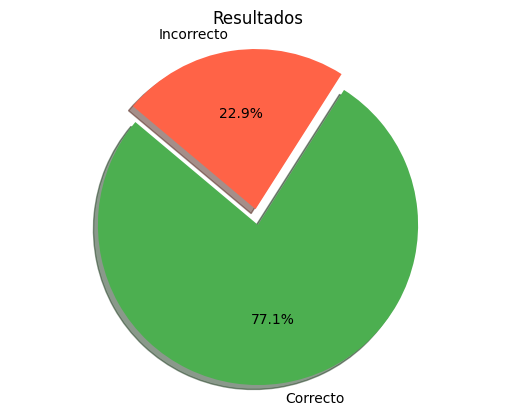

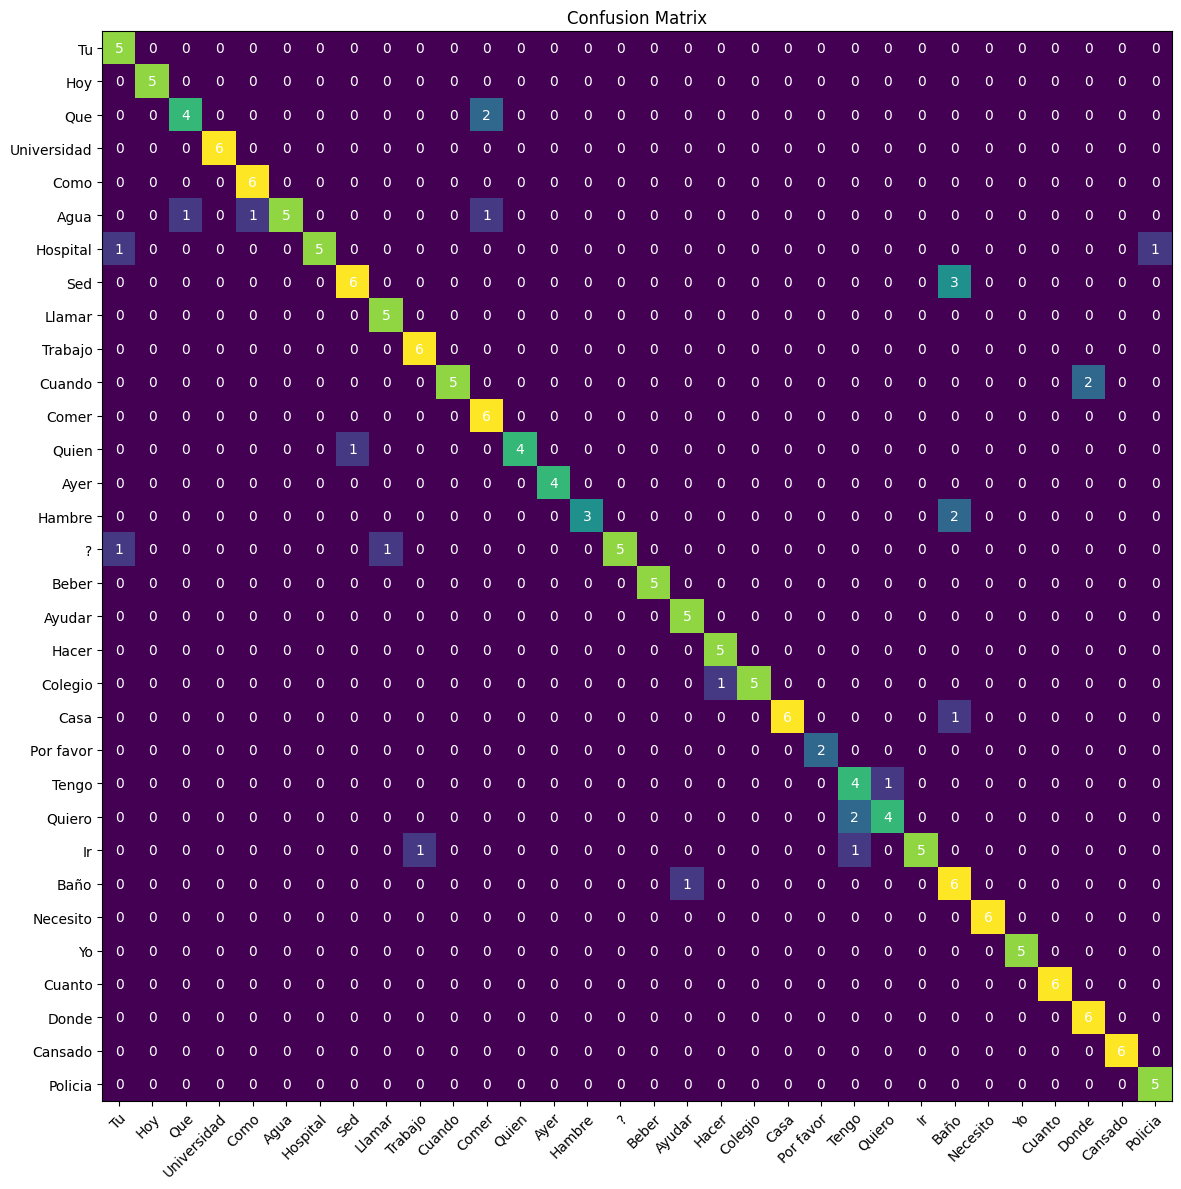

Colegio recognized as: None
Cuando recognized as: None
Hoy recognized as: None
Hambre recognized as: None
Tu recognized as: None
Que recognized as: Comer
Quien recognized as: Sed
Hacer recognized as: None
Sed recognized as: Sed Baño
Ayer recognized as: None
Tengo recognized as: Quiero
Por favor recognized as: None
Agua recognized as: Comer
Cuando recognized as: Cuando Donde
Por favor recognized as: None
Policia recognized as: None
Quiero recognized as: Tengo
Colegio recognized as: Colegio Hacer
Ayudar recognized as: None
Ir recognized as: Trabajo Ir
Hambre recognized as: None
Ir recognized as: None
Baño recognized as: Baño Ayudar
Accuracy:  0.7708333333333334
Average FPS:  19.668564530536408
Recall:  0.8821800595238094
Precision:  0.8970982142857142
F1-Score:  0.8895765971253534


In [35]:
metrics = evaluateModel(tf.keras.models.load_model('Models/baseModel.keras'))
print("Accuracy: ", metrics["Accuracy"])
print("Average FPS: ", metrics["Average FPS"])
print("Recall: ", metrics["Recall"])
print("Precision: ", metrics["Precision"])
print("F1-Score: ", metrics["F1-Score"])

  0%|          | 0/97 [00:00<?, ?it/s]/Users/ls/Documents/Projects/python-lensegua/venv/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
100%|██████████| 97/97 [09:32<00:00,  5.91s/it]


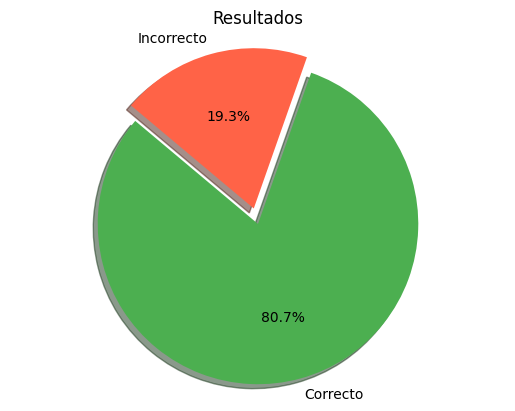

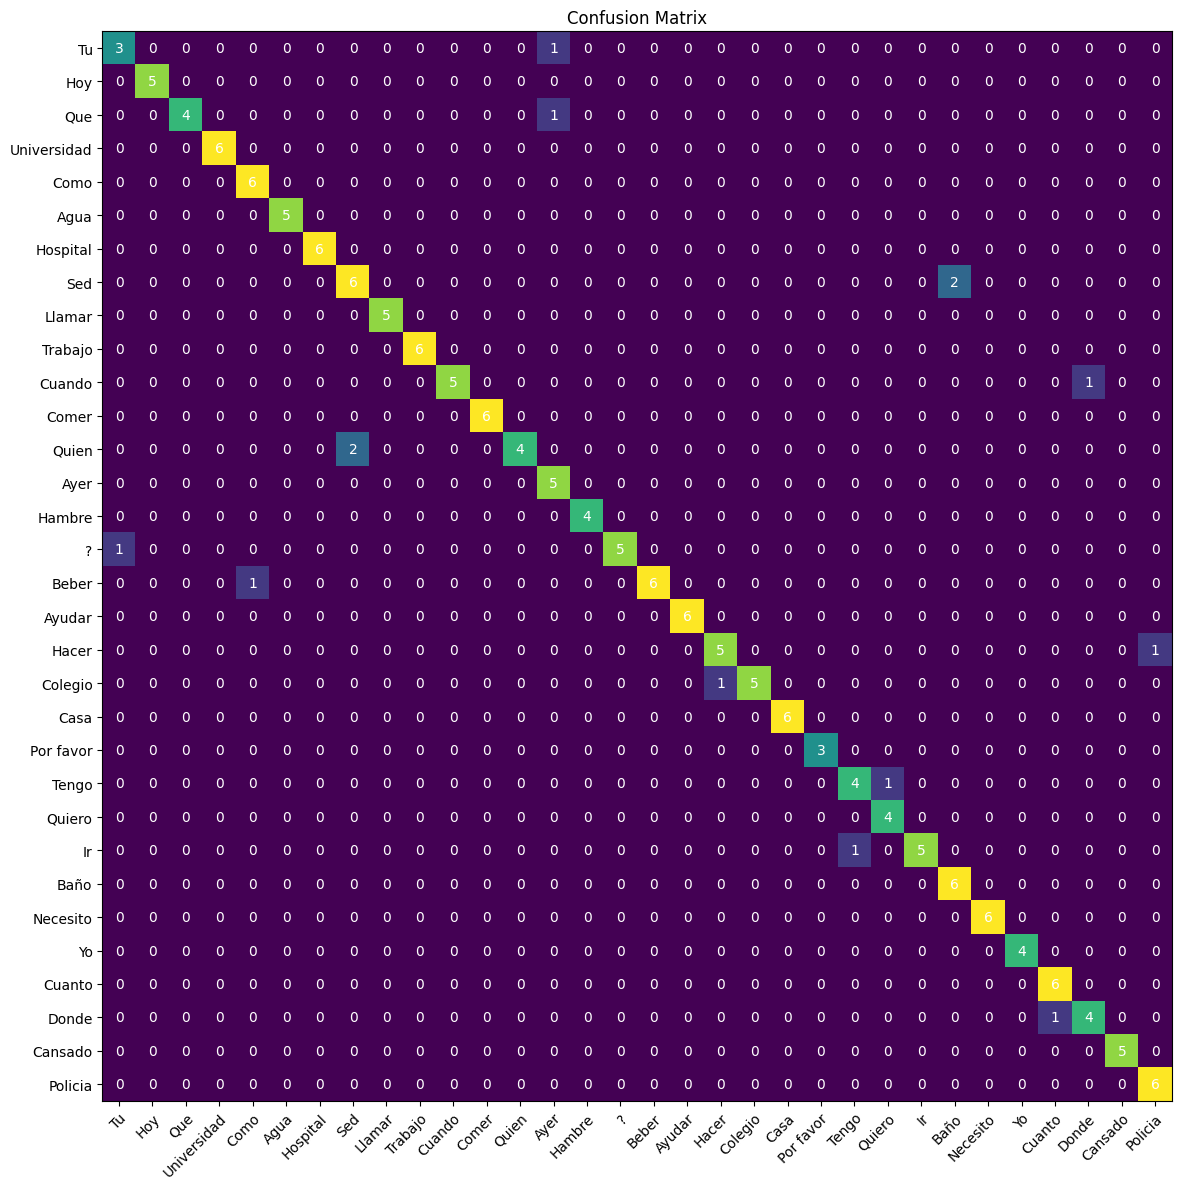

Colegio recognized as: None
Hacer recognized as: Hacer Policia
Cuando recognized as: None
Beber recognized as: Beber Como
Hoy recognized as: None
Tu recognized as: Ayer
Que recognized as: Ayer
Quien recognized as: Sed
Hacer recognized as: None
Sed recognized as: Sed Baño
Tengo recognized as: Quiero
Por favor recognized as: None
Tu recognized as: None
Agua recognized as: None
Por favor recognized as: None
Quiero recognized as: None
Colegio recognized as: Colegio Hacer
Ayer recognized as: None
Donde recognized as: Cuanto
Hambre recognized as: None
Yo recognized as: None
Ir recognized as: None
Donde recognized as: None
Accuracy:  0.8072916666666666
Average FPS:  19.667046161545535
Recall:  0.9247023809523809
Precision:  0.9302827380952381
F1-Score:  0.9274841658214767


In [36]:
metrics = evaluateModel(tf.keras.models.load_model('Models/modelDropout.keras'))
print("Accuracy: ", metrics["Accuracy"])
print("Average FPS: ", metrics["Average FPS"])
print("Recall: ", metrics["Recall"])
print("Precision: ", metrics["Precision"])
print("F1-Score: ", metrics["F1-Score"])

  0%|          | 0/97 [00:00<?, ?it/s]/Users/ls/Documents/Projects/python-lensegua/venv/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
100%|██████████| 97/97 [09:40<00:00,  5.98s/it]


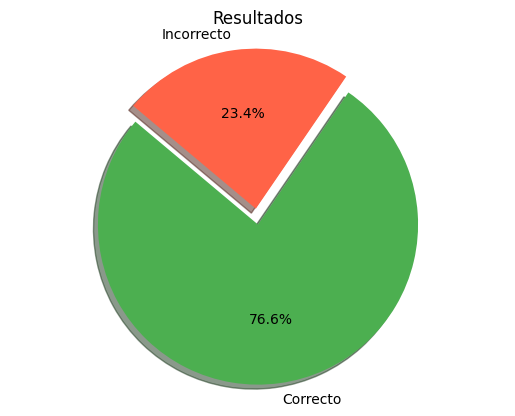

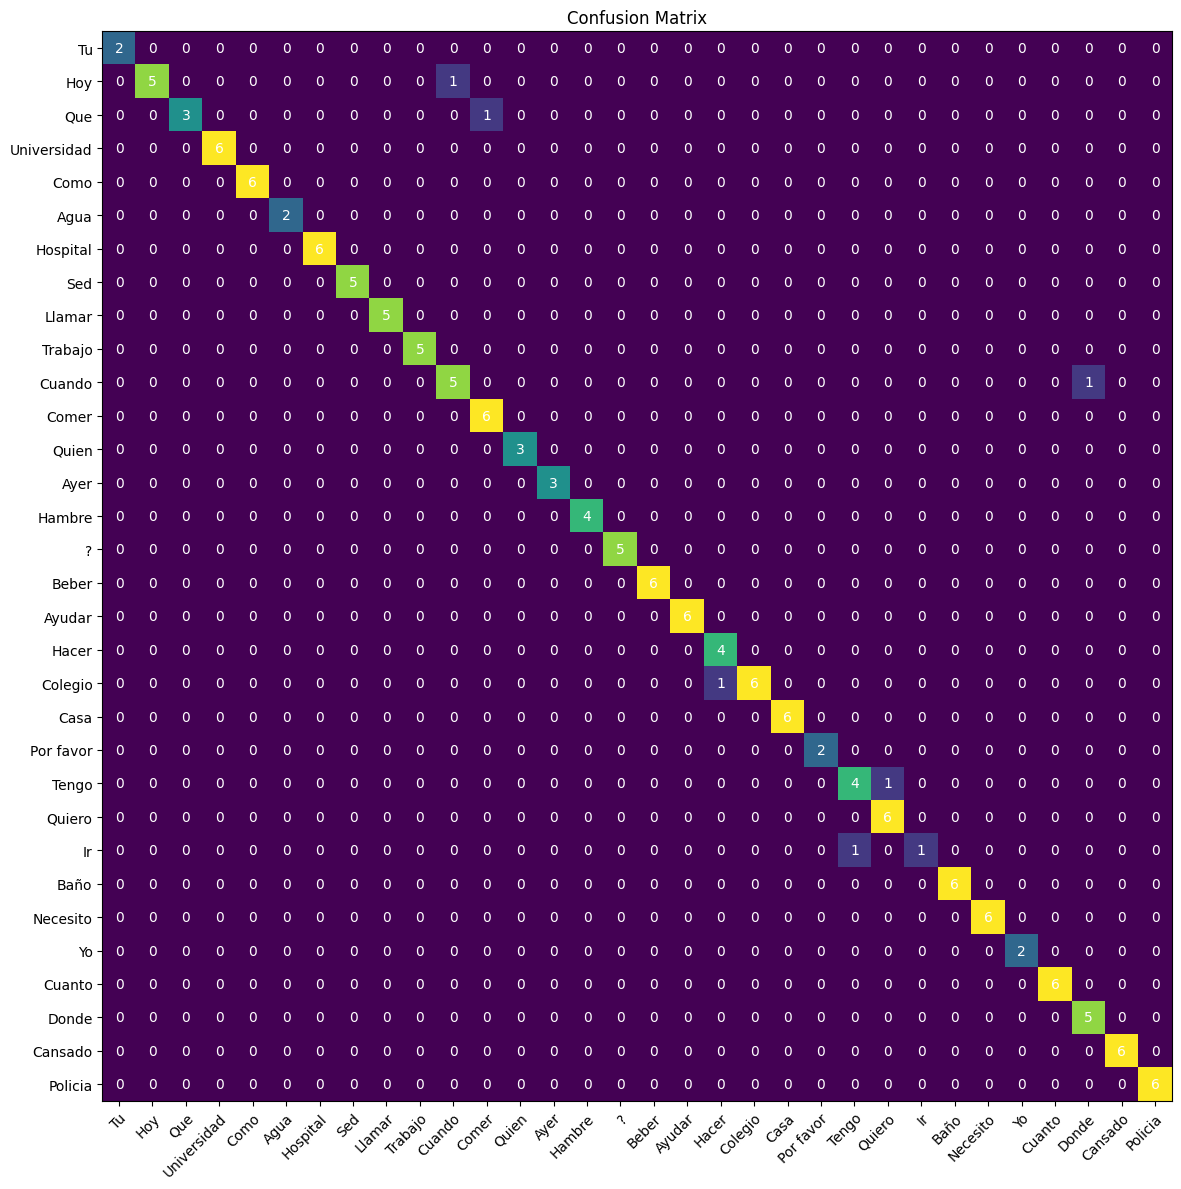

Cuando recognized as: None
Hoy recognized as: Cuando
Tu recognized as: None
Que recognized as: Comer
Quien recognized as: None
Quien recognized as: None
Agua recognized as: None
Hacer recognized as: None
Ayer recognized as: None
Tengo recognized as: Quiero
Por favor recognized as: None
Tu recognized as: None
Agua recognized as: None
Que recognized as: None
Tu recognized as: None
Agua recognized as: None
Por favor recognized as: None
Colegio recognized as: Colegio Hacer
Yo recognized as: None
Ir recognized as: None
Ayer recognized as: None
Donde recognized as: None
Hambre recognized as: None
Que recognized as: None
Yo recognized as: None
Ir recognized as: None
Trabajo recognized as: None
Accuracy:  0.765625
Average FPS:  19.52986409041917
Recall:  0.9554315476190477
Precision:  0.9681547619047619
F1-Score:  0.9617510770602289


In [37]:
metrics = evaluateModel(tf.keras.models.load_model('Models/modelDropoutV2.keras'))
print("Accuracy: ", metrics["Accuracy"])
print("Average FPS: ", metrics["Average FPS"])
print("Recall: ", metrics["Recall"])
print("Precision: ", metrics["Precision"])
print("F1-Score: ", metrics["F1-Score"])

  0%|          | 0/97 [00:00<?, ?it/s]/Users/ls/Documents/Projects/python-lensegua/venv/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
100%|██████████| 97/97 [09:44<00:00,  6.03s/it]


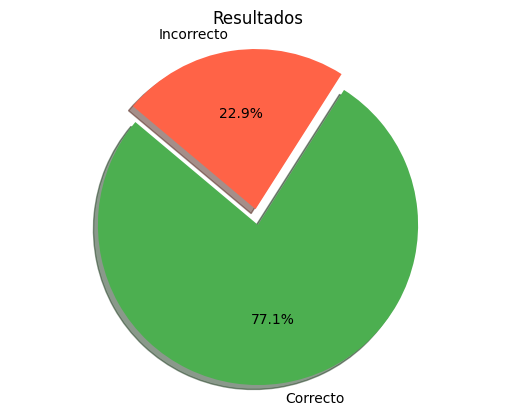

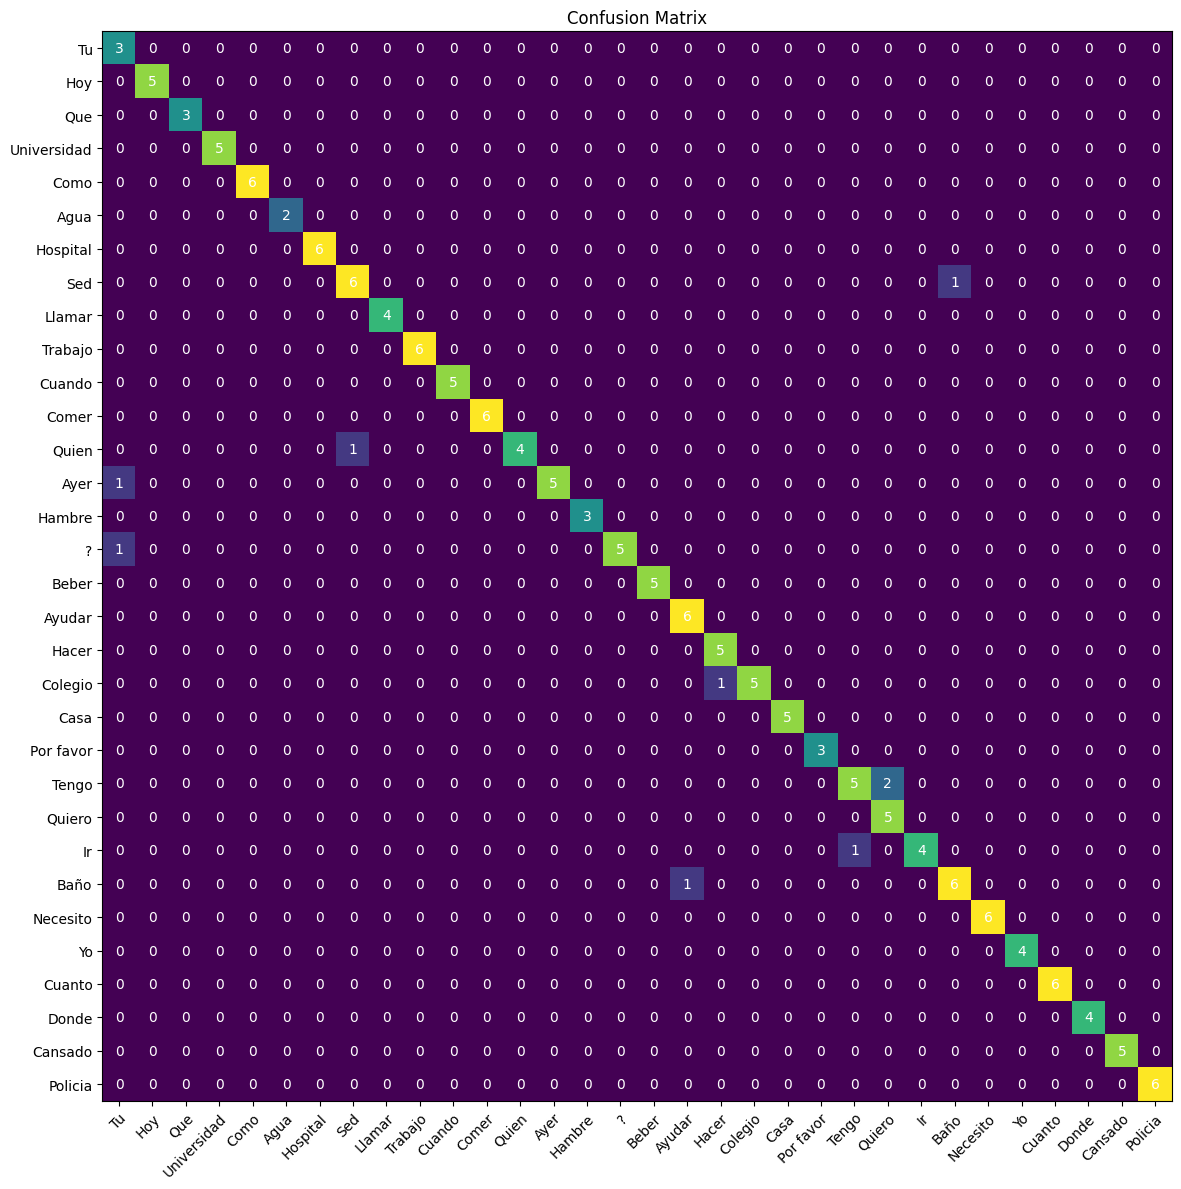

Ayer recognized as: Ayer Tu
Cuando recognized as: None
Hoy recognized as: None
Hambre recognized as: None
Tu recognized as: None
Que recognized as: None
Quien recognized as: None
Agua recognized as: None
Casa recognized as: None
Hacer recognized as: None
Sed recognized as: Sed Baño
Tengo recognized as: Quiero
Por favor recognized as: None
Tu recognized as: None
Agua recognized as: None
Llamar recognized as: None
Agua recognized as: None
Por favor recognized as: None
Colegio recognized as: Colegio Hacer
Tengo recognized as: Tengo Quiero
Ayer recognized as: None
Hambre recognized as: None
Que recognized as: None
Ir recognized as: None
Baño recognized as: Baño Ayudar
Donde recognized as: None
Accuracy:  0.7708333333333334
Average FPS:  19.52726191891758
Recall:  0.9540178571428571
Precision:  0.9547619047619048
F1-Score:  0.9543897359364734


In [38]:
metrics = evaluateModel(tf.keras.models.load_model('Models/modelDropoutV3.keras'))
print("Accuracy: ", metrics["Accuracy"])
print("Average FPS: ", metrics["Average FPS"])
print("Recall: ", metrics["Recall"])
print("Precision: ", metrics["Precision"])
print("F1-Score: ", metrics["F1-Score"])

  0%|          | 0/97 [00:00<?, ?it/s]/Users/ls/Documents/Projects/python-lensegua/venv/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
100%|██████████| 97/97 [09:47<00:00,  6.05s/it]


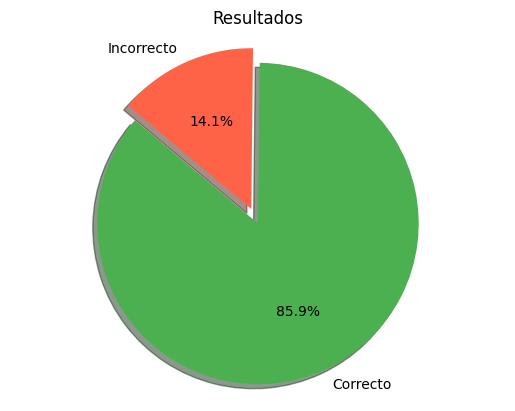

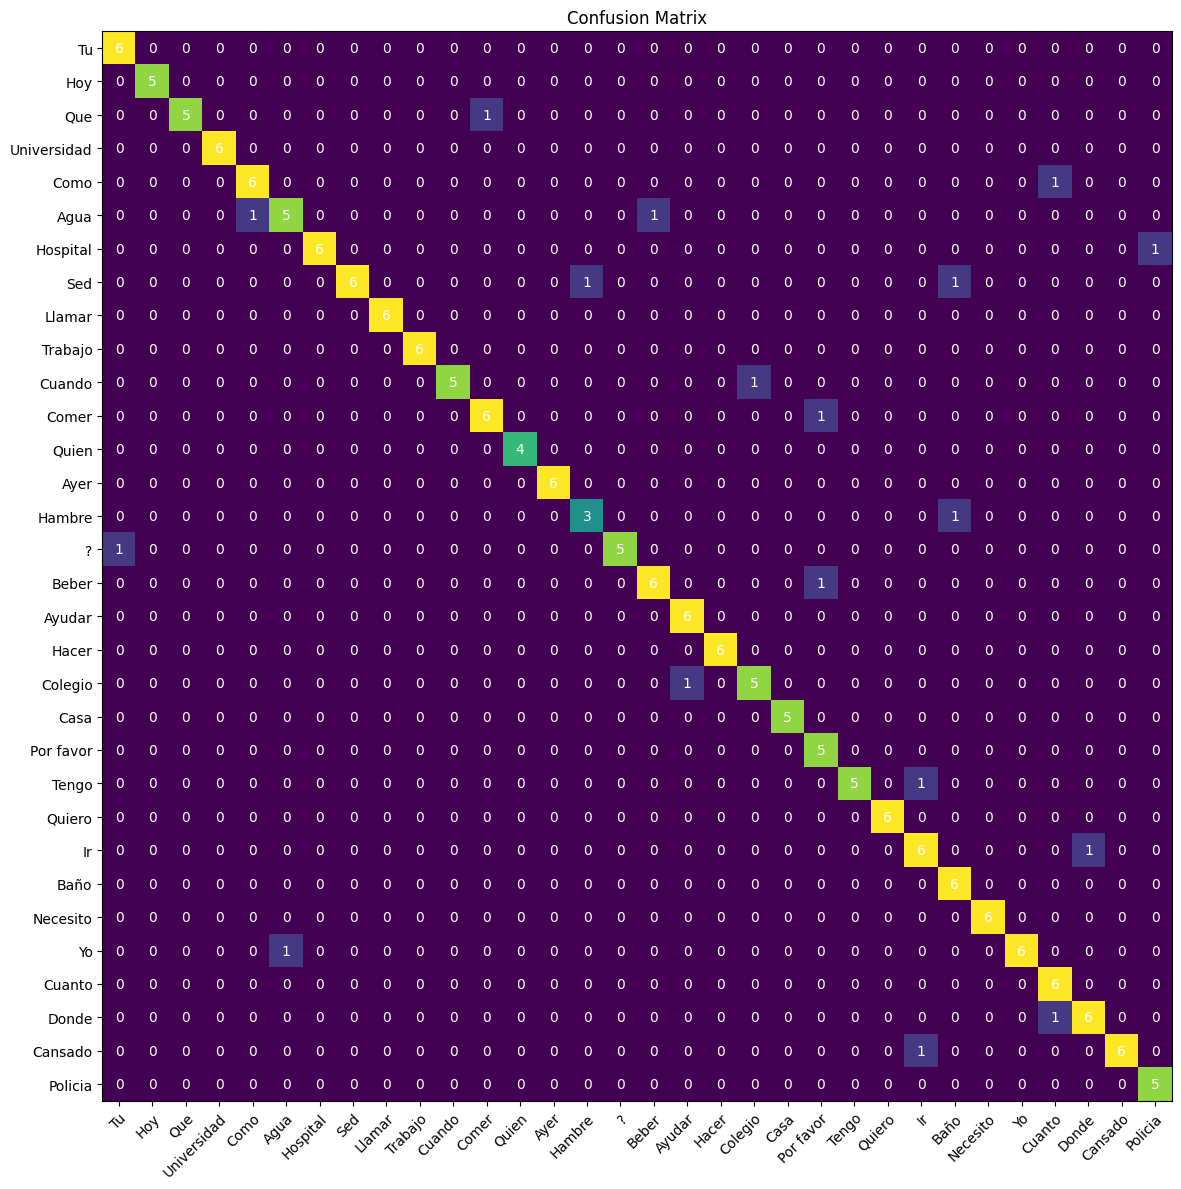

Cuando recognized as: Colegio
Hoy recognized as: None
Que recognized as: Comer
Como recognized as: Como Cuanto
Quien recognized as: None
Casa recognized as: None
Sed recognized as: Sed Baño
Tengo recognized as: Ir
Agua recognized as: Beber
Sed recognized as: Hambre Sed
Agua recognized as: Agua Como
Por favor recognized as: None
Colegio recognized as: Colegio Ayudar
Donde recognized as: Donde Cuanto
Hambre recognized as: None
Ir recognized as: Ir Donde
Yo recognized as: Agua Yo
Accuracy:  0.859375
Average FPS:  19.262522625729694
Recall:  0.9136904761904763
Precision:  0.9174107142857144
F1-Score:  0.9155468160445812


In [39]:
metrics = evaluateModel(tf.keras.models.load_model('Models/modelBN.keras'))
print("Accuracy: ", metrics["Accuracy"])
print("Average FPS: ", metrics["Average FPS"])
print("Recall: ", metrics["Recall"])
print("Precision: ", metrics["Precision"])
print("F1-Score: ", metrics["F1-Score"])

  0%|          | 0/97 [00:00<?, ?it/s]/Users/ls/Documents/Projects/python-lensegua/venv/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
100%|██████████| 97/97 [09:46<00:00,  6.04s/it]


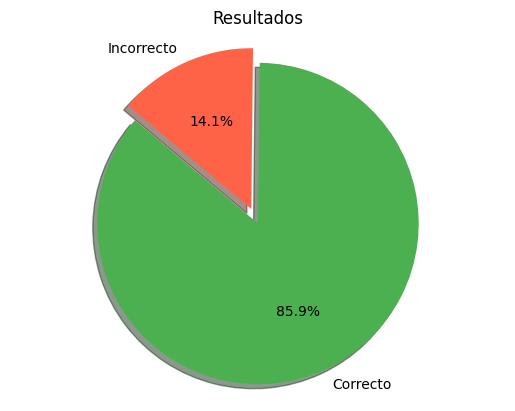

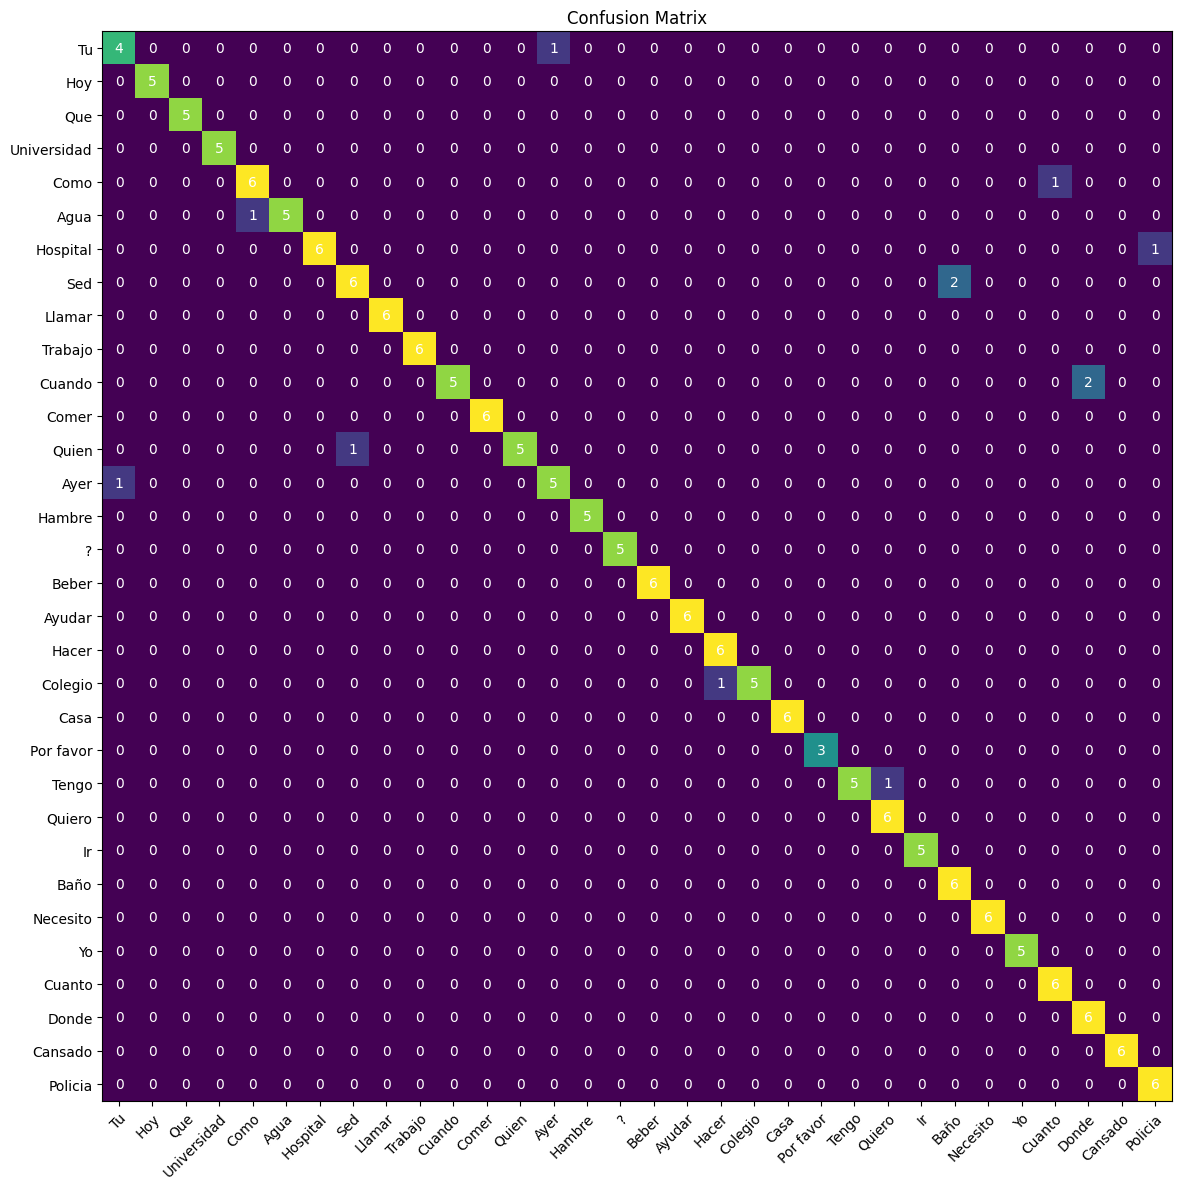

Colegio recognized as: None
Cuando recognized as: None
Hoy recognized as: None
Tu recognized as: Ayer
Que recognized as: None
Universidad recognized as: None
Como recognized as: Como Cuanto
Quien recognized as: Sed
Sed recognized as: Sed Baño
Tengo recognized as: Quiero
Por favor recognized as: None
Tu recognized as: None
Agua recognized as: None
Cuando recognized as: Cuando Donde
Por favor recognized as: None
Colegio recognized as: Colegio Hacer
Ayer recognized as: None
Hambre recognized as: None
Ir recognized as: None
Accuracy:  0.859375
Average FPS:  19.208996984587372
Recall:  0.9420386904761905
Precision:  0.9461309523809525
F1-Score:  0.944080386814457


In [40]:
metrics = evaluateModel(tf.keras.models.load_model('Models/modelDropoutBN.keras'))
print("Accuracy: ", metrics["Accuracy"])
print("Average FPS: ", metrics["Average FPS"])
print("Recall: ", metrics["Recall"])
print("Precision: ", metrics["Precision"])
print("F1-Score: ", metrics["F1-Score"])

  0%|          | 0/97 [00:00<?, ?it/s]/Users/ls/Documents/Projects/python-lensegua/venv/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
100%|██████████| 97/97 [09:45<00:00,  6.03s/it]


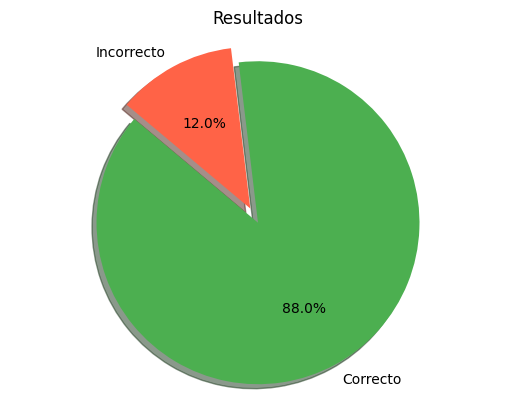

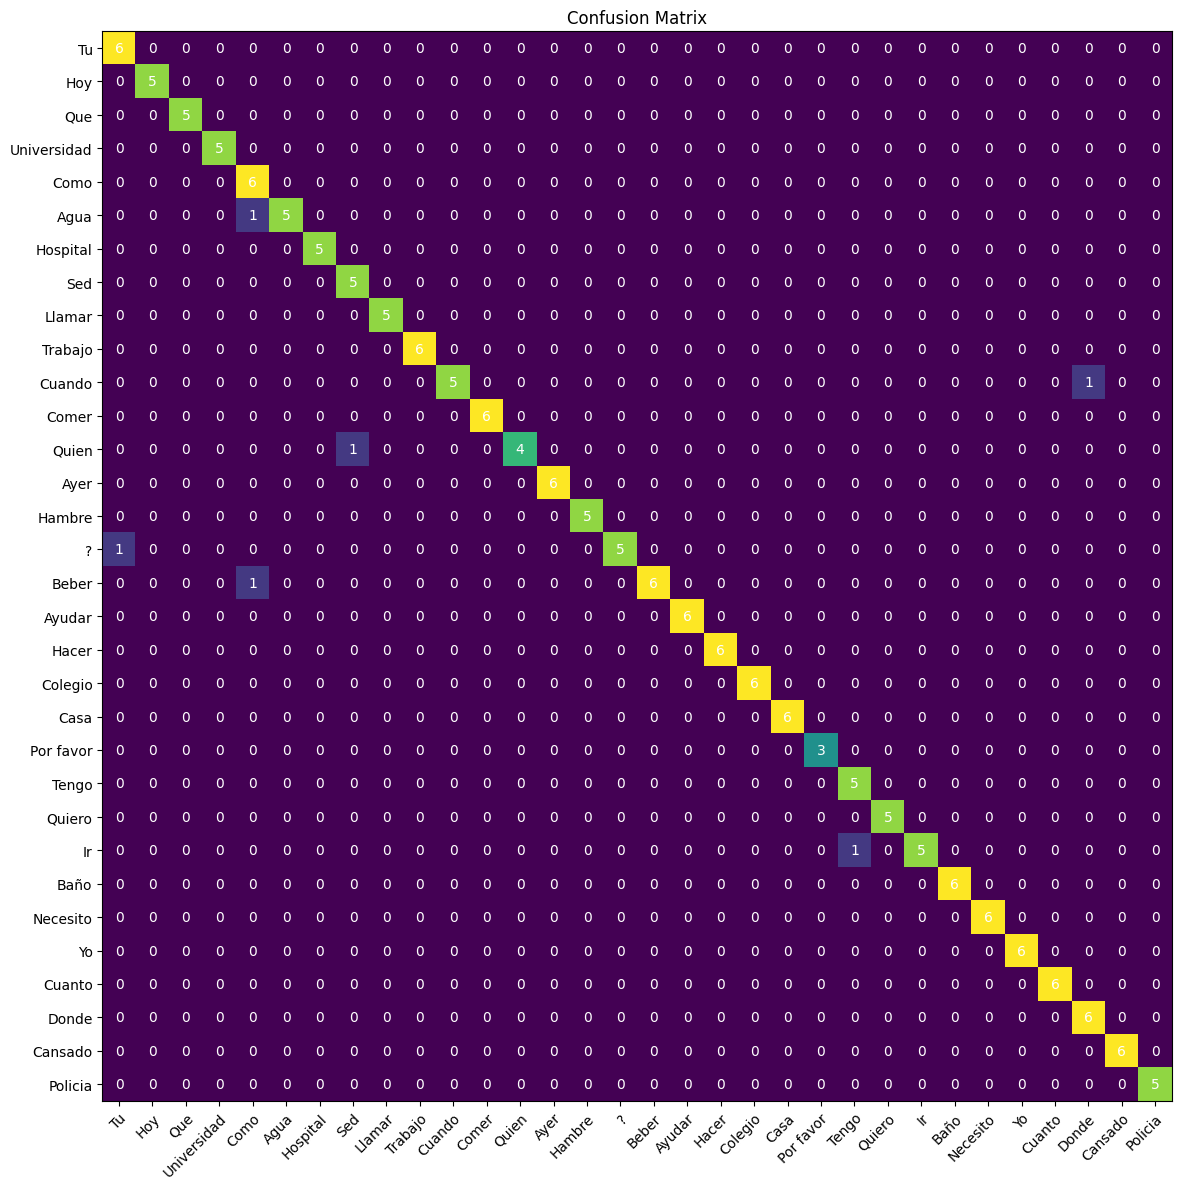

Cuando recognized as: None
Hoy recognized as: None
Que recognized as: None
Universidad recognized as: None
Quien recognized as: None
Tengo recognized as: None
Por favor recognized as: None
Agua recognized as: None
Cuando recognized as: Cuando Donde
Por favor recognized as: None
Policia recognized as: None
Ir recognized as: None
Accuracy:  0.8802083333333334
Average FPS:  19.387410930845782
Recall:  0.9684523809523811
Precision:  0.972842261904762
F1-Score:  0.9706423579741965


In [43]:
metrics = evaluateModel(tf.keras.models.load_model('Models/modelDropoutBNV2.keras'))
print("Accuracy: ", metrics["Accuracy"])
print("Average FPS: ", metrics["Average FPS"])
print("Recall: ", metrics["Recall"])
print("Precision: ", metrics["Precision"])
print("F1-Score: ", metrics["F1-Score"])

  0%|          | 0/97 [00:00<?, ?it/s]/Users/ls/Documents/Projects/python-lensegua/venv/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
100%|██████████| 97/97 [09:40<00:00,  5.98s/it]


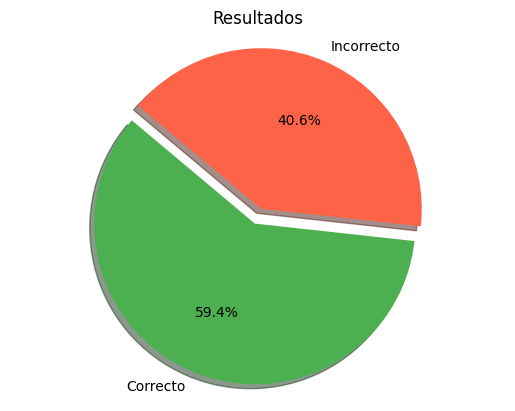

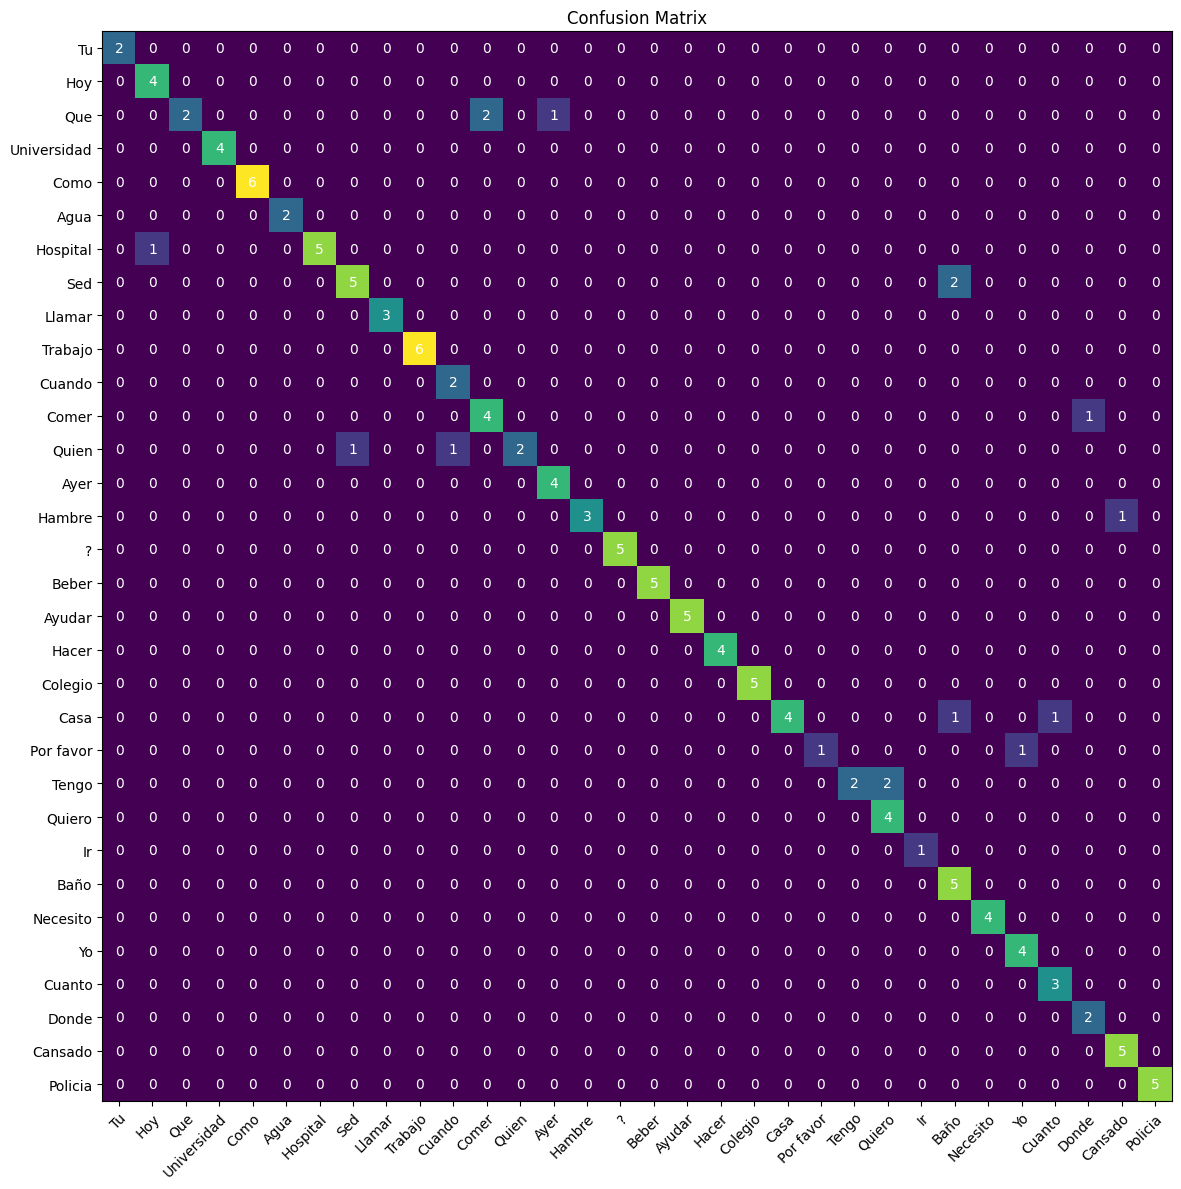

Hoy recognized as: None
Colegio recognized as: None
Cuando recognized as: None
Hoy recognized as: None
Hambre recognized as: Cansado
Tu recognized as: None
Que recognized as: Comer Ayer
Universidad recognized as: None
Cuando recognized as: None
Quien recognized as: None
Llamar recognized as: None
Agua recognized as: None
Casa recognized as: Cuanto
Hacer recognized as: None
Hacer recognized as: None
Sed recognized as: Sed Baño
Ayer recognized as: None
Tengo recognized as: Quiero
Por favor recognized as: None
Tu recognized as: None
Agua recognized as: None
Quien recognized as: None
Llamar recognized as: None
Cuando recognized as: None
Agua recognized as: None
Comer recognized as: None
Por favor recognized as: None
Policia recognized as: None
Quiero recognized as: None
Ayudar recognized as: None
Necesito recognized as: None
Necesito recognized as: None
Ir recognized as: None
Ayer recognized as: None
Casa recognized as: None
Hambre recognized as: None
Baño recognized as: None
Donde recogni

In [41]:
metrics = evaluateModel(tf.keras.models.load_model('Models/modelComplex.keras'))
print("Accuracy: ", metrics["Accuracy"])
print("Average FPS: ", metrics["Average FPS"])
print("Recall: ", metrics["Recall"])
print("Precision: ", metrics["Precision"])
print("F1-Score: ", metrics["F1-Score"])

  0%|          | 0/28 [00:00<?, ?it/s]/Users/ls/Documents/Projects/python-lensegua/venv/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
100%|██████████| 28/28 [04:13<00:00,  9.06s/it]
/var/folders/mm/7cr01mmd5dn8q0ldchj4p97c0000gn/T/ipykernel_96218/2100963725.py:18: RuntimeWarning: invalid value encountered in divide
  recall = np.diag(combinedConfusionMatrix) / np.sum(combinedConfusionMatrix, axis=1)
/var/folders/mm/7cr01mmd5dn8q0ldchj4p97c0000gn/T/ipykernel_96218/2100963725.py:21: RuntimeWarning: invalid value encountered in divide
  precision = np.diag(combinedConfusionMatrix) / np.sum(combinedConfusionMatrix, axis=0)


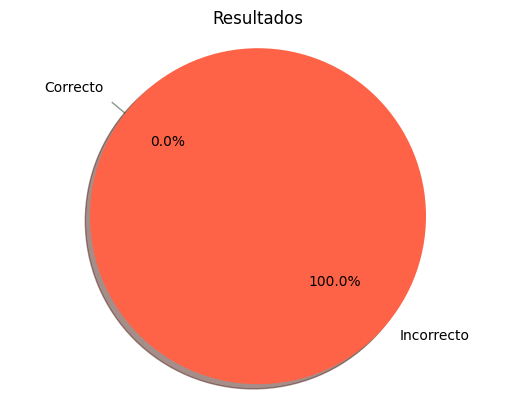

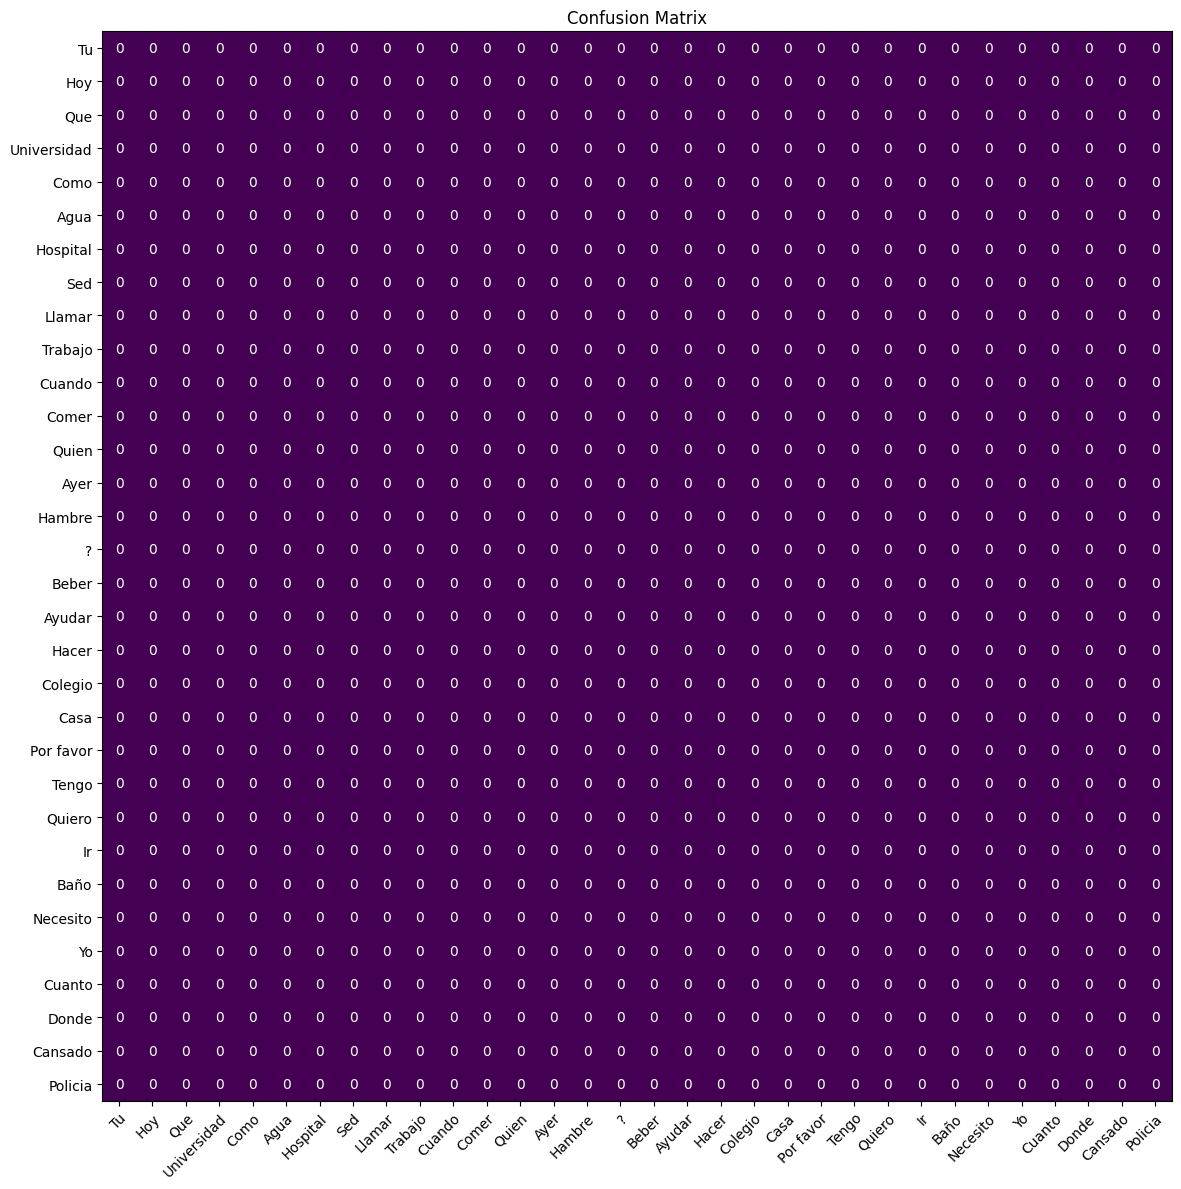

Hoy Universidad Ir recognized as: Ir
Hoy Universidad Ir recognized as: 
Hoy Universidad Ir recognized as: 
Por favor Tu Llamar Policia recognized as: Llamar
Hoy Universidad Ir recognized as: 
Hoy Universidad Ir recognized as: Ir
Por favor Tu Llamar Policia recognized as: Llamar Policia
Hoy Universidad Ir recognized as: 
Por favor Tu Llamar Policia recognized as: Llamar
Hoy Universidad Ir recognized as: Comer
Por favor Tu Llamar Policia recognized as: Llamar
Hoy Universidad Ir recognized as: Beber Ir
Por favor Tu Llamar Policia recognized as: 
Por favor Tu Llamar Policia recognized as: Llamar
Hoy Universidad Ir recognized as: 
Por favor Tu Llamar Policia recognized as: 
Por favor Tu Llamar Policia recognized as: 
Por favor Tu Llamar Policia recognized as: 
Donde Baño? recognized as: Donde ?
Donde Baño ? recognized as: Comer
Donde Baño ? recognized as: 
Donde Baño? recognized as: 
Donde Baño? recognized as: 
Donde Baño ? recognized as: Comer Tu
Donde Baño ? recognized as: Donde ?
Donde B

In [10]:
metrics = evaluateModel(tf.keras.models.load_model('Models/modelDropoutBNV2.keras'), True)
print("Accuracy: ", metrics["Accuracy"])
print("Average FPS: ", metrics["Average FPS"])
print("Recall: ", metrics["Recall"])
print("Precision: ", metrics["Precision"])
print("F1-Score: ", metrics["F1-Score"])